In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

In [8]:
ratings_df = pd.read_csv("book-data/ratings.csv")
books_df = pd.read_csv("book-data/books.csv")

ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [9]:
books_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [10]:
print(ratings_df.shape)
print(ratings_df.user_id.nunique())
print(ratings_df.book_id.unique())

ratings_df.isna().sum()

(981756, 3)
53424
[    1     2     3 ...  9998  9999 10000]


book_id    0
user_id    0
rating     0
dtype: int64

In [13]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"shape of train data: {Xtrain.shape}")
print(f"shape of test data: {Xtest.shape}")

shape of train data: (785404, 3)
shape of test data: (196352, 3)


In [15]:
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()

In [23]:
#Book input network
input_books = tf.layers.Input(shape = [1])
embed_books = tf.layers.Embedding(nbook_id + 1, 15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1, 15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

In [25]:
opt = tf.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=opt, loss='mean_squared_error')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 15)        150015      input_10[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 15)        801375      input_11[0][0]                   
______________________________________________________________________________________________

In [28]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, batch_size = 64, epochs=5, verbose=1, validation_data = ([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/5
12272/12272 [==============================] - 129s 10ms/step - loss: 0.8586 - val_loss: 0.7118
Epoch 2/5
12272/12272 [==============================] - 133s 11ms/step - loss: 0.6836 - val_loss: 0.7038
Epoch 3/5
12272/12272 [==============================] - 132s 11ms/step - loss: 0.6468 - val_loss: 0.6986
Epoch 4/5
12272/12272 [==============================] - 127s 10ms/step - loss: 0.6166 - val_loss: 0.7066
Epoch 5/5
12272/12272 [==============================] - 127s 10ms/step - loss: 0.5865 - val_loss: 0.7121


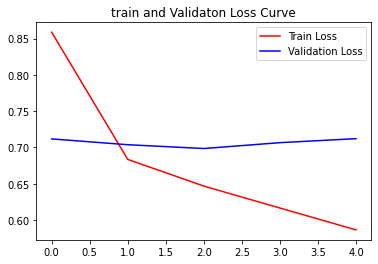

In [29]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("train and Validaton Loss Curve")
plt.legend()
plt.show()

In [31]:
# Extract embeddings
book_em = model.get_layer('Embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

ValueError: No such layer: Embedding.